In [1]:
import os
import pandas as pd
from scipy import stats
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import preprocessing

# Inspection of data

In [2]:
def load_data(filename):
    """
    It loads the data from the csv file to a pandas Dataframe.
    :param filename: str
    :return: pandas Dataframe
    """
    parent_dir = os.getcwd()
    df = pd.read_csv(os.path.join(parent_dir, filename))

    return df

In [3]:
filename_train = 'ds_dmp_task_1_take_home.csv'
df_train = load_data(filename=filename_train)

In [4]:
df_train.head()

,user,provider,age,url,ua,city
0,user3,provider1,60+,https://www.domain763.de/panorama/id_84336484/...,Mozilla/5.0 (Linux; Android 6.0.1; SM-G903F Bu...,dortmund
1,user3,provider1,60+,https://www.domain763.de/panorama/id_84336484/...,Mozilla/5.0 (Linux; Android 6.0.1; SM-G903F Bu...,dortmund
2,user10,provider2,50-59,https://dlvr.domain763.de/static/lisa/placemen...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,althengstett
3,user28,provider1,30-39,https://www.domain235.de/testsieger/level3_far...,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,NaN
4,user71,provider2,40-49,https://www.domain763.de/,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,NaN


From the dataset we have the following features:
- Independent variables: user, provider, url, ua (user agent)
- Dependent variable: age, categorical variable of age groups: '60+', '50-59', '30-39', '40-49', '20-29'

In [5]:
df_train.dtypes

user        object
provider    object
age         object
url         object
ua          object
city        object
dtype: object

At the first moment, the duplicated values were dropped from the dataframe. In thia way almost 100000 data points will not be included in the model, whose performance in the multi-class classification was really low (around 0.36 weighted f1 score). I realized that by keeping the duplicates values, the model could perfom better.  

In [6]:
# df_train.drop_duplicates(inplace=True)

Information about the percentage of missing values in the dataset : we can see that the feature with the highest number of missing values is represented by city. As rule, a feature is removed from the traning data when it contains 20% or more of missing values. In this case the feature is not removed because it has only 9% of missing values.

In [7]:
df_nan = df_train.isna()
print("percentage of missing values:\n", (df_nan.sum()/len(df_nan)*100))

percentage of missing values:
 user        0.0000
provider    0.0000
age         0.0000
url         0.8236
ua          0.0460
city        9.1692
dtype: float64


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 6 columns):
user        250000 non-null object
provider    250000 non-null object
age         250000 non-null object
url         247941 non-null object
ua          249885 non-null object
city        227077 non-null object
dtypes: object(6)
memory usage: 11.4+ MB


Age group is sorted from the smallest to the biggest age group's value

In [9]:
order = ['20-29', '30-39', '40-49', '50-59', '60+']
df_train['age'] = pd.Categorical(df_train['age'], order)

In [10]:
df_train.sort_values("age", inplace=True)

The age group label is transformed to an integer. The new column is called 'integer_age'

In [11]:
le = preprocessing.LabelEncoder()
df_train['integer_age'] = le.fit_transform(df_train['age'])

In [12]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'20-29': 0, '30-39': 1, '40-49': 2, '50-59': 3, '60+': 4}


We create a dataframe of the age distribution in the web inventory for visualisation reasons.

In [13]:
age_distr_dummy = {'age':['20-29', '30-39', '40-49', '50-59', '60+'], 'percentage':[0.3, 0.3, 0.15, 0.15,0.1]}
df_age_distr = pd.DataFrame.from_dict(age_distr_dummy)

Three plots are displayed: 
1. The age distribution in the we inventory
2. The age distribution for the provider 1
3. The age distribution for the provider 2

[Text(0,0.5,'percentage'), Text(0.5,0,'age')]

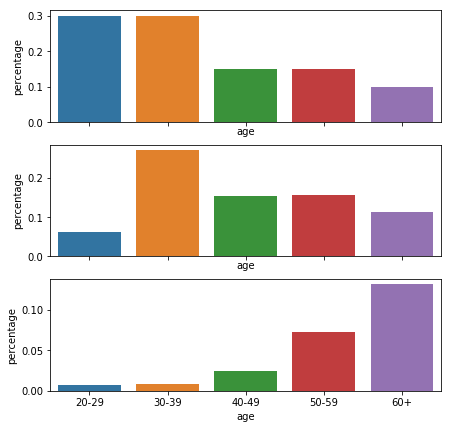

In [14]:
f, axes = plt.subplots(3,figsize=(7, 7), sharex=True)
xlabel = 'age'
ylabel = 'percentage'
sn.barplot(x="age", y="percentage", data=df_age_distr, ax=axes[0])
sn.barplot(x="age", y="integer_age", data=df_train.loc[df_train.provider=='provider1'], 
                estimator=lambda x: len(x) / len(df_train), ax=axes[1])
sn.barplot(x="age", y="integer_age", data=df_train.loc[df_train.provider=='provider2'], 
                estimator=lambda x: len(x) / len(df_train), ax=axes[2])
axes[0].set(xlabel=xlabel, ylabel=ylabel)

We can see that the distribution of the provider 1 is closer to the age distribution in the web inventory and for this reason, the data from provider 1 is chosen for the age group prediction. Furtheremore, since we are dealing with an imbalance dataset, the percentage of each age group in the web inventory will be used as class weights for the model. In fact, in this case the age distribution in the web inventory represents the population distribution.

# Feature creation

From the user agent the browser, os and device type name will be parsed.

In [15]:
from ua_parser import user_agent_parser
df_train['browser'] = df_train['ua'].apply(lambda x: 
        user_agent_parser.ParseUserAgent(x)['family'] if isinstance(x, str) else None)
df_train['os'] = df_train['ua'].apply(lambda x: 
        user_agent_parser.ParseOS(x)['family'] if isinstance(x, str) else None)
df_train['device'] = df_train['ua'].apply(lambda x: 
        user_agent_parser.ParseDevice(x)['family'] if isinstance(x, str) else None)

From the user agent the url domain will be parsed.

In [16]:
import urllib
df_train['url_domain'] = df_train.url.apply(lambda x: urllib.parse.urlsplit(x).netloc.split(".")[1]
                                if isinstance(x, str) else None)

From feature city, new features are created: region, longitude, latitude, country, population.

In [17]:
import json
import requests

def get_info_city_opendata(city):
    """
    It fetches information about the city (geopoint, country, population, etc.)
    :param city: string
    :return: dict/None
    if None : the city has not been found. Otherwise dictionary.
    """
    tmp = 'https://public.opendatasoft.com/api/records/1.0/search/?dataset=worldcitiespop&q=%s'
    cmd = tmp % (city)
    res = requests.get(cmd)
    dct = json.loads(res.content)
    try:
        out = dct['records'][0]['fields']
    except:
        out = None
    return out

I provided already the saved dataframe with the additional information about the city.

In [18]:
# df_city.to_csv('df_city.csv', index=False)
filename_city = 'df_city.csv'
df_city = load_data(filename=filename_city)

In [19]:
# df_city = pd.DataFrame(df_train.city.dropna().unique(), columns=['raw_city_name'])
# df_city['info_city'] = df_city.raw_city_name.apply(lambda row: get_info_city_opendata(row))
# df_city.dropna(inplace=True)
# for feature in ['accentcity', 'country', 'region', 'latitude', 'longitude', 'population']:
#     df_city[feature] = df_city.info_city.apply(lambda row: 
#                     row[feature] if isinstance(row, dict) and feature in row.keys() else None)

Based on people density, the city is defined as either village or town or city. Usually older people would live in small city or villages compared to younger people.

In [20]:
df_city['settlement_type'] = None
df_city.loc[df_city.population<2500, 'settlement_type'] = 'village'
df_city.loc[(df_city.population>2500) & (df_city.population<100000), 'settlement_type'] = 'town'
df_city.loc[df_city.population>100000, 'settlement_type'] = 'city'

Merge of additional features about the city to the original dataframe

In [21]:
df_total = pd.merge(df_train, df_city[['city_name', 'country', 'region', 'population',
                                       'latitude', 'longitude', 'settlement_type']], how='left',
                                        left_on=['city'], right_on=['city_name'])

Imputation of missing values from the dataframe.

In [22]:
df_total.dropna(inplace=True)

In [23]:
df_total.columns

Index(['user', 'provider', 'age', 'url', 'ua', 'city', 'integer_age',
       'browser', 'os', 'device', 'url_domain', 'city_name', 'country',
       'region', 'population', 'latitude', 'longitude', 'settlement_type'],
      dtype='object')

Visualization of age distributions and city type. Two remarks must be made:
1. for city and town the distributions of age groups are really similar
2. for settlement type village there are not observations.

It must be said that I have noticed that there are many city mismatches, particularly for village.

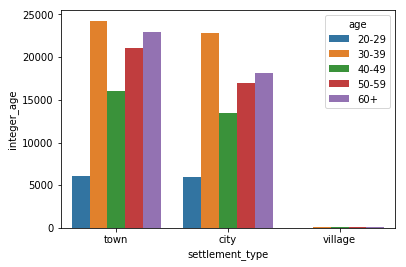

In [24]:
sn.barplot(data=df_total[['integer_age', 'settlement_type', 'age']],
            x='settlement_type', y='integer_age', hue="age",  estimator=lambda x: len(x))

Since for the features browser, device, os and url_domain, many values have a frequency in the dataset lower than 1%, those data are replaced with the feature mode.

In [25]:
cols_low_freq = ['browser', 'device', 'os', 'url_domain']
for col in cols_low_freq:
    print(df_total[col].value_counts().tail(10))

BlackBerry WebKit           10
Mail.ru Chromium Browser    10
Opera Mini                   3
Puffin                       2
HbbTV                        1
Pale Moon                    1
UC Browser                   1
WebKit Nightly               1
Sogou Explorer               1
Dragon                       1
Name: browser, dtype: int64
Captiva PAD 10.1 Quad FHD 3G    1
VIA_A1                          1
SurfTab breeze 7.0 quad         1
Micromax P024                   1
LG-H870S                        1
TPC-XE10D-H                     1
Archos 70d Titanium             1
Microsoft Lumia 532 Dual SIM    1
TPC-XE7DW                       1
S31                             1
Name: device, dtype: int64
Mac OS X          2932
Ubuntu             346
Linux              244
Windows Phone      215
Chrome OS           66
BlackBerry OS       10
Other                9
Tizen                6
Fedora               4
Windows NT 4.0       3
Name: os, dtype: int64
domain612    1
domain589    1
domain808   

In [26]:
def replace_mode_for_low_freq(cols, df_temp, threshold=0.01):
    """
    For the values with an occurrence frequency less than 1%,
    the feature mode is replaced.
    :param cols: list of strings
    List of features columns.
    :param df_temp: DataFrame
    :param threshold: float
    Frequency occurrence threshold. 
    :return: DataFrame
    """
    for col in cols:
        val = df_temp[col].value_counts(normalize=True)
        y = val[val < threshold].index
        mode_value = df_temp[col].mode()[0]
        df_temp[col] = df_temp[col].replace({x: None for x in y})
        df_temp[col].fillna(mode_value, inplace=True)
    return df_temp

df_total = replace_mode_for_low_freq(cols=cols_low_freq, df_temp=df_total)

Label encoding for the categorical features chosen for the traning: ['browser', 'user', 'os', 'url_domain', 'city', 'country', 'device']

In [27]:
categorical_features = ['browser', 'user', 'os', 'url_domain', 'city', 'country', 'device']

In [28]:
for col in categorical_features:
    df_total['integer_'+col] = le.fit_transform(df_total[col])

Only transforming the labels into integers can be a bit too dangerous. Indeed the model can misunderstand the data to be in some kind of oder. So the one hot encoding usually is also used.
One hot encoding splits the column into multiple columns. The numbers are replaced by 1s and 0s, depending on which column has what value.

But since we use tree-based algorithms and one-hot encoding actually makes the performance worse. In general categorical variables are naturally disadvantaged in this case since tree-based algorithms have only a few options for splitting. The situation gets worse in variables that have a small number of levels and one-hot encoding falls in this category with just two levels. The trees generally tend to grow in one direction because at every split of a categorical variable there are only two values (0 or 1). The tree grows in the direction of zeroes in the dummy variables. And in this way we introduce sparsity which is not desirable.

In [112]:
df_total.columns

Index(['user', 'provider', 'age', 'url', 'ua', 'city', 'integer_age',
       'browser', 'os', 'device', 'url_domain', 'city_name', 'country',
       'region', 'population', 'latitude', 'longitude', 'settlement_type',
       'integer_browser', 'integer_user', 'integer_os', 'integer_url_domain',
       'integer_city', 'integer_country', 'integer_device'],
      dtype='object')

# Model selection
Most tree based ensemble techniques are efficient for imbalanced datasets. Tree based ensemble models work by combining predictions from multiple models (trees) trained on samples from the original dataset. Hence for a given record its class label is determined based on the majority vote from the individual trees.

For this reason, I have chosen random forest and extra tree classifiers. An ensemble of randomly trained decision trees make up a random forest. The most important concept of a random forest is that each randomly trained decision is randomly different from another. This is what leads to its great generalization abilities. A class of random forest is represented by the extra tree (also called extreme random forests): the main difference to the random forest is that instead of computing the locally optimal feature/split combination (for the random forest), for each feature under consideration, a random value is selected for the split (for the extra trees).
Furthemore, the Gradient Boosting classifier has been used as well. Indeed Gradient Boosting Machines deals with class imbalance by constructing successive training sets based on incorrectly classified examples.

The extra tree classifier turned out to be the most performant.

We choose to filter the data only for the provider1, for which the distribution is closer to that one from the web inventory.

In [95]:
df_prov1 = df_total.loc[df_total.provider == 'provider1']

In [96]:
data = df_prov1[['integer_browser', 'integer_user', 'integer_os', 'integer_url_domain',
                 'integer_city', 'integer_country', 'integer_device', 
                 'population', 'latitude', 'longitude', 'integer_age']]

# Cross-validation
The cross validation with 3 folds has been executed on the training set for the independent and dependent variables on the two proposed prediction models. The weighted f1 score is calculated across the three folds. The highest average of  f1 score determines which model is selected. 

Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes. In fact F1 score gives a better measure of the incorrectly classified cases.

A macro-f1 score will compute the metric independently for each class (treating all classes equally), whereas a micro-f1 score will aggregate the contributions of all classes. In a multi-class classification setup, micro-metric is preferable if you suspect there might be class imbalance.

In [175]:
from sklearn.ensemble import RandomForestClassifier,  ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [149]:
X = data.drop(columns=['integer_age'], axis=1).values
Y = data[['integer_age']].values

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
cv_folds = 3
class_weights = {0: 3.5, 1: 1, 2: 1, 3: 1, 4: 1}

In [150]:
def train_test_km(df, target_var, test_size):
    """
    The dataset is split in training and test data based on the test_size
    The Kolmogorov-Smirnov statistics is executed to verify weather the feature
    distributions between train and test are not significantly dissimilar.
    :param df: pandas Dataframe
    :param test_size: float
    :return: numpy array, numpy array, numpy array, numpy array
    """
    Y = df[target_var].values
    df_ = df.drop(columns=target_var)
    X = df_.values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
                                                        random_state=42)
    # Kolmogorov-Smirnov statistics
    # to check whether the data come from the same distribution
    xtrain = pd.DataFrame(X_train, columns=df_.columns)
    xtest = pd.DataFrame(X_test, columns=df_.columns)
    for col in df_:
        _, pvalue = stats.ks_2samp(xtrain[col], xtest[col])
        if pvalue < 0.05:
            print("For the feature {}, the distributions of train and test"
                  "samples are significantly dissimilar with a p-value of {}."
                  .format(col, str(pvalue)))

    return X_train, X_test, y_train, y_test

In [152]:
# splitting the data in train and test sets
X_train, X_test, y_train, y_test = \
    train_test_km(df=data, target_var="integer_age", test_size=0.30)

In [154]:
list_scores = []
models = [RandomForestClassifier(class_weight=class_weights),
          ExtraTreesClassifier(class_weight=class_weights),
          GradientBoostingClassifier()]

for model in models:
    scores = cross_val_score(model, X_train, y_train,
                             cv=cv_folds,
                             scoring='f1_micro')
    list_scores.append(np.mean(scores))
chosen_model = models[list_scores.index(np.max(list_scores))]

In [155]:
print('Highest F1 score (micro) on the training = {}'.format(str(np.max(list_scores))))
print(chosen_model)

Highest F1 score (micro) on the training = 0.6167010657044901
ExtraTreesClassifier(bootstrap=False,
                     class_weight={0: 3.5, 1: 1, 2: 1, 3: 1, 4: 1},
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators='warn', n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)


# Tuning
For the Extra Tree classifier the tuning concerns tree- and boosting-related parameters. 

For the tree-related paramenters we have:
- max number of features: number of features to consider while deciding for each split
- minimum samples of split: number of samples necessary to allow the tree split
- minumum samples of leaf: number of samples to define a leaf
- max tree depth: max depth to ensure no further split although the minimum sample split has been reached.

For the hyperparamenters:
- number of estimators: number of modelled trees before the prediction is made

In [156]:
# param_grid = {
#               'n_estimators': [100, 500, 1000],
#               'max_depth': [2, 3, 5, 7],
#               'max_features': list(range(1,X_train.shape[1])),
#               'min_samples_leaf': [1, 3, 5, 7, 9],
#               'min_samples_split': [2, 4, 6, 8, 10,
#                                     20, 40, 60, 100],
#               'random_state': [1]
#                 }
# grid_search = GridSearchCV(estimator=chosen_model,
#                            param_grid =param_grid,
#                            cv=cv_folds,
#                            n_jobs=-1,
#                            verbose=1)
# grid_search.fit(X_train, y_train)

In [157]:
# print('Best : {}, using {}'.format(grid_search.best_score_,grid_search.best_params_))

In [158]:
# tuned_model = ExtraTreesClassifier(class_weight=class_weights, **grid_search.best_params_)

In [159]:
tuned_model = ExtraTreesClassifier(class_weight=class_weights)

In [182]:
scores = cross_val_score(tuned_model, X_train, y_train,
                             cv=cv_folds,
                             scoring='f1_micro')

In [184]:
print(scores)

[0.61877169 0.6159081  0.61434539]


In [186]:
print('Average F1 score (micro) on the training = {}'.format(str(np.mean(scores))))

Average F1 score (micro) on the training = 0.6163417258519974


In [179]:
tuned_model.fit(X_train, y_train)
preds_tuned = tuned_model.predict(X_test)

In [181]:
print(classification_report(y_test, preds_tuned))
print(f1_score(y_test, preds_tuned, average='micro'))

              precision    recall  f1-score   support

           0       0.45      0.35      0.40      3261
           1       0.73      0.78      0.75     13855
           2       0.71      0.70      0.71      7610
           3       0.75      0.75      0.75      7789
           4       0.76      0.74      0.75      5649

    accuracy                           0.72     38164
   macro avg       0.68      0.66      0.67     38164
weighted avg       0.71      0.72      0.71     38164

0.7150979981134055


In [1]:
predictors = list(data.drop(columns='integer_age').columns)
feat_imp = pd.Series(tuned_model.feature_importances_, 
                     predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

NameError: name 'data' is not defined

In [108]:
df_prov2 = df_total.loc[df_total.provider == 'provider2']
data_prov2 = df_prov2[['integer_browser', 'integer_user', 'integer_os', 'integer_url_domain',
                 'integer_city', 'integer_country', 'integer_device', 
                 'population', 'latitude', 'longitude', 'integer_age']]

In [109]:
X_prov2 = data_prov2.drop(columns=['integer_age'], axis=1).values
Y_prov2 = data_prov2[['integer_age']].values

In [110]:
prov2_pred = tuned_model.predict(X_prov2)

In [111]:
print(classification_report(Y_prov2, prov2_pred))
print(f1_score(Y_prov2, prov2_pred, average='micro'))

              precision    recall  f1-score   support

           0       0.05      0.08      0.06      1220
           1       0.04      0.20      0.06      1335
           2       0.10      0.20      0.13      3968
           3       0.28      0.28      0.28     12025
           4       0.57      0.28      0.38     22363

    accuracy                           0.27     40911
   macro avg       0.21      0.21      0.18     40911
weighted avg       0.41      0.27      0.31     40911

0.26567426853413506


# Responses to questions

- 3.a) The need for more data occurs in the case of high variance, which is when the error in the traning set is lower than test data. High variance is can be solved with more data or regularization methods. In this case the problem the training error is not that different from the test error but it is really high. So what we have is high bias problem, which can be solved by feature engineering but also by changing the algorithm.

- 3.b) One simpler solution would be to see the distribution of the age groups and change the weights to the class 20-29; another solution would be to apply One-Vs-The-Rest classification.
